Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from glob import glob

In [3]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/Data_Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/Data_Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/gdrive/MyDrive/Colab Notebooks/Data_Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(180, 180),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/gdrive/MyDrive/Colab Notebooks/Data_Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(180, 180),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

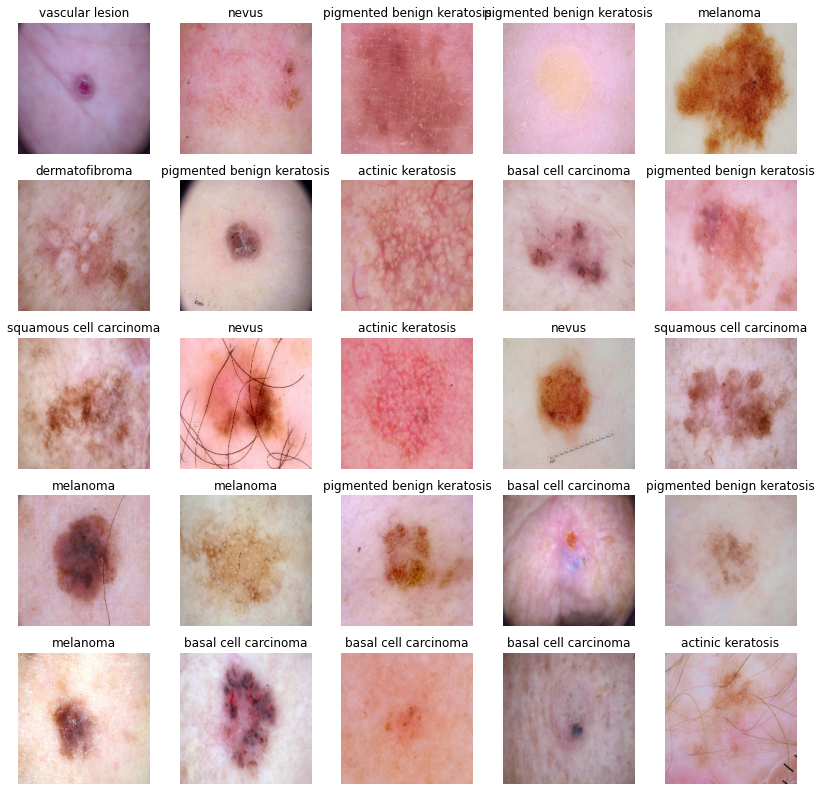

In [10]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(14, 14))
for images, labels in train_ds.take(1):
    for i in range(25):         
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [11]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
normalizing_layer = tf.keras.layers.Rescaling(scale = 1/255, offset=0.0,)

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalizing_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.17450981 0.8818628


In [15]:
#Making the model with 3 convolution layer (with 16, 32 and 64 numbers of features respectively) and then flattening it to a vector of size 128 and 
#finally converting it into 9 classifications. We are using relu activation function in each layer except the last one. In the last one softmax function is used.

In [16]:
### Your code goes here

num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [17]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [19]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 42s 548ms/step - loss: 1.9534 - accuracy: 0.2963 - val_loss: 1.7753 - val_accuracy: 0.3333
Epoch 2/20
56/56 [==============================] - 1s 25ms/step - loss: 1.6470 - accuracy: 0.4174 - val_loss: 1.4949 - val_accuracy: 0.5168
Epoch 3/20
56/56 [==============================] - 1s 23ms/step - loss: 1.4414 - accuracy: 0.4894 - val_loss: 1.4625 - val_accuracy: 0.5034
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3615 - accuracy: 0.5145 - val_loss: 1.4934 - val_accuracy: 0.4989
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.2533 - accuracy: 0.5474 - val_loss: 1.4592 - val_accuracy: 0.4720
Epoch 6/20
56/56 [==============================] - 1s 23ms/step - loss: 1.1955 - accuracy: 0.5709 - val_loss: 1.3198 - val_accuracy: 0.5503
Epoch 7/20
56/56 [==============================] - 1s 23ms/step - loss: 1.0982 - accuracy: 0.6110 - val_loss: 1.2951 - val_accuracy: 0.5727
Epoch 8/20
56/56 [====

### Visualizing training results

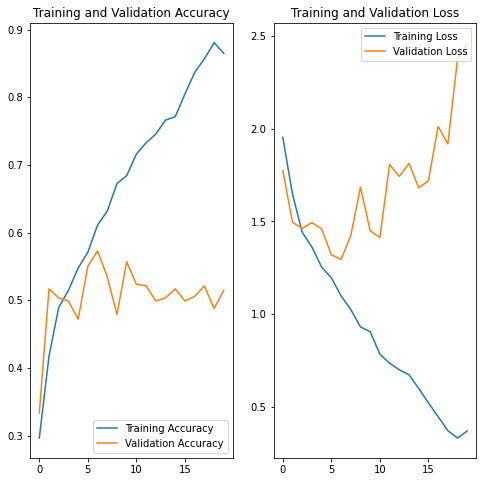

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

In [21]:
##There is a large gap between the training and validation accuracy. The validation accuracy is around 55 percent. This shows the model is clearly overfiting. 
##To reduce the overfitting we will include data augmentation and drop out.


##First we are using data augmentation

##In this we are flipping horizontally, rotating by a factor of 0.1 and zooming by a factor of 0.1.

### Write your findings here

In [22]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

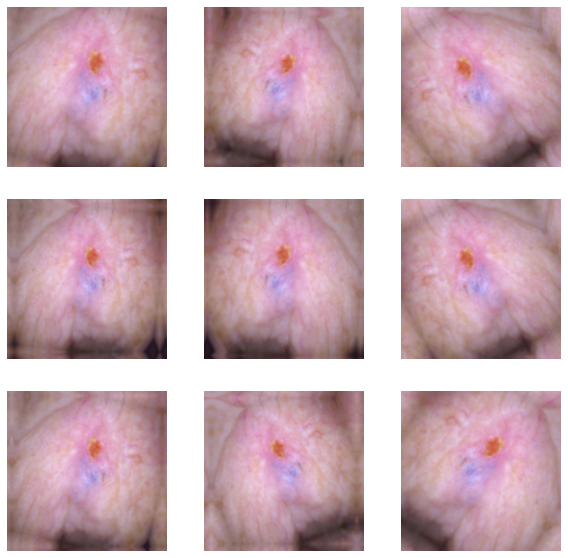

In [23]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [24]:
##Now againg making the model with data_augmentation and using a 20 percent drop out after every pooling layer 

In [25]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])


### Compiling the model

In [26]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 90, 90, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                      

### Training the model

In [28]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 3s 33ms/step - loss: 2.3606 - accuracy: 0.2143 - val_loss: 1.9837 - val_accuracy: 0.2506
Epoch 2/20
56/56 [==============================] - 2s 29ms/step - loss: 1.7215 - accuracy: 0.3717 - val_loss: 1.7305 - val_accuracy: 0.4004
Epoch 3/20
56/56 [==============================] - 2s 29ms/step - loss: 1.6006 - accuracy: 0.4258 - val_loss: 1.5667 - val_accuracy: 0.4564
Epoch 4/20
56/56 [==============================] - 2s 29ms/step - loss: 1.5505 - accuracy: 0.4431 - val_loss: 1.6170 - val_accuracy: 0.4407
Epoch 5/20
56/56 [==============================] - 2s 29ms/step - loss: 1.5306 - accuracy: 0.4503 - val_loss: 1.4847 - val_accuracy: 0.4631
Epoch 6/20
56/56 [==============================] - 2s 29ms/step - loss: 1.4955 - accuracy: 0.4587 - val_loss: 1.4973 - val_accuracy: 0.5056
Epoch 7/20
56/56 [==============================] - 2s 29ms/step - loss: 1.4856 - accuracy: 0.4794 - val_loss: 1.5196 - val_accuracy: 0.4787
Epoch 8/20
56/56 [======

### Visualizing the results

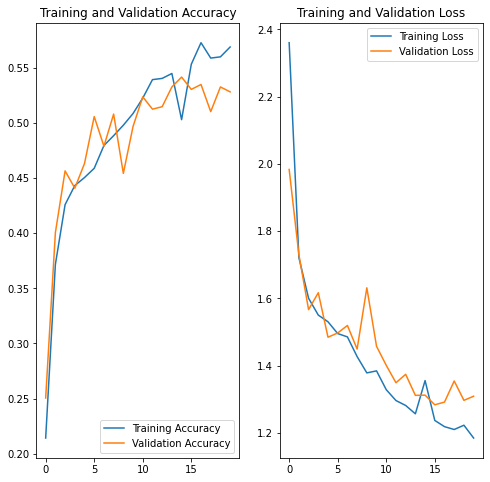

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

In [30]:
##Now the model is not over fitting. The training, validation accuracy and losses are nearly same. The validation accuracy is 53 percent. 
##There is improvement as compared to the previous model but the model is surely underfit as the accuract of training drops drastically

In [31]:
##Now adding 500 augumented images to each 9 categories

##Before that we will make a data frame having the number of images in each categories and we will see the class imbalance among the categories

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [32]:
## Your code goes here.

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [33]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [34]:
# Creating the list of paths for each images in the training data set
old_path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
old_path_list

['/content/gdrive/MyDrive/Colab Notebooks/Data_Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0027334.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Data_Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0027958.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Data_Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0027172.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Data_Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0028314.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Data_Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0028393.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Data_Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0030036.jpg',
 '/content/gdrive/MyDrive/Colab No

In [35]:
path_to_training_dataset="/content/gdrive/MyDrive/Colab Notebooks/Data_Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Data_Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7EB036AF10>: 100%|██████████| 500/500 [00:19<00:00, 26.15 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Data_Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7EB03DF490>: 100%|██████████| 500/500 [00:18<00:00, 26.71 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Data_Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7EB0336850>: 100%|██████████| 500/500 [00:19<00:00, 25.78 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Data_Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2816x2112 at 0x7F7EB0374850>: 100%|██████████| 500/500 [01:31<00:00,  5.45 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Data_Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=853x680 at 0x7F7EB03DF110>: 100%|██████████| 500/500 [01:22<00:00,  6.04 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Data_Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7EB5026F10>: 100%|██████████| 500/500 [00:19<00:00, 26.17 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Data_Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F7EB4FC0850>: 100%|██████████| 500/500 [00:42<00:00, 11.77 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Data_Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7EB1C0DAD0>: 100%|██████████| 500/500 [00:19<00:00, 25.70 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Data_Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7EB1C4D1D0>: 100%|██████████| 500/500 [00:19<00:00, 26.24 Samples/s]


In [36]:
# Now creating the list of lables of the images in the training data without including the additional 500 images of each categories
lesion_list_old = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train,'*' ,'*.jpg'))]
lesion_list_old

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [ ]:
##Now adding 500 augumented images of each categories in the output folder created in each respective category folders

##Creating the pipeline of the augmentor and doing the rotation

In [37]:
#Creating a dictionary of the image path and lable
dataframe_dict_old= dict(zip(old_path_list, lesion_list_old))

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [38]:
#Creating a data frame of the dictionary
original_df = pd.DataFrame(list(dataframe_dict_old.items()),columns = ['Path','Label'])

In [39]:
original_df

,Path,Label
0,/content/gdrive/MyDrive/Colab Notebooks/Data_M...,actinic keratosis
1,/content/gdrive/MyDrive/Colab Notebooks/Data_M...,actinic keratosis
2,/content/gdrive/MyDrive/Colab Notebooks/Data_M...,actinic keratosis
3,/content/gdrive/MyDrive/Colab Notebooks/Data_M...,actinic keratosis
4,/content/gdrive/MyDrive/Colab Notebooks/Data_M...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/Colab Notebooks/Data_M...,seborrheic keratosis
2235,/content/gdrive/MyDrive/Colab Notebooks/Data_M...,seborrheic keratosis
2236,/content/gdrive/MyDrive/Colab Notebooks/Data_M...,seborrheic keratosis
2237,/content/gdrive/MyDrive/Colab Notebooks/Data_M...,seborrheic keratosis


In [40]:
#Showing the class imbalance before adding the 500 images to each categories
original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

In [41]:
data_var = pd.DataFrame(original_df['Label'].value_counts())

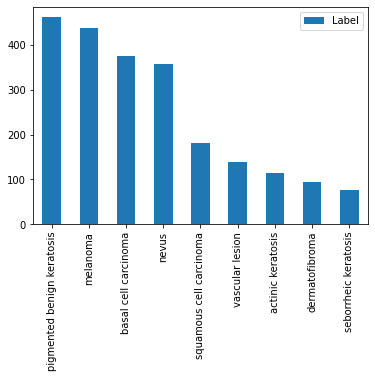

In [42]:
data_var.plot.bar()

In [ ]:
##As it is clearly visible from the bar plot that there is a class embalance existing as pigmented benign keratosis is having 462 images and 
##seborrheic keratosis is having only 77 images

In [ ]:
##To reduce this class imbalance we had added 500 augumented images to each categories 

In [43]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [44]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Colab Notebooks/Data_Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029830.jpg_0ac8c3fe-87e1-40bd-a570-1bb9df7374d6.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Data_Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025957.jpg_e646c932-61da-4b3b-b2eb-b2efd254a629.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Data_Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027950.jpg_112bc57d-49eb-47e4-b2ad-83b5d7534932.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Data_Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029840.jpg_af858811-29ae-40fa-ad02-354232fb77f7.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Data_Melanoma/

In [45]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [47]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [48]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [49]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [50]:
data_var_2 = new_df['Label'].value_counts()

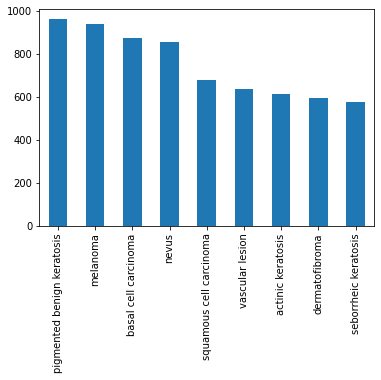

In [51]:
data_var_2.plot.bar()

In [52]:
##Now the class imbalance is less as compared to the previous one.

#### **Todo**: Train the model on the data created using Augmentor

In [53]:
batch_size = 32
img_height = 180
img_width = 180

In [55]:
# Now againg making a new training data from the new set of data created (with 80 percent)
data_dir_train=r'/content/gdrive/MyDrive/Colab Notebooks/Data_Melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [58]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size = (img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [59]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

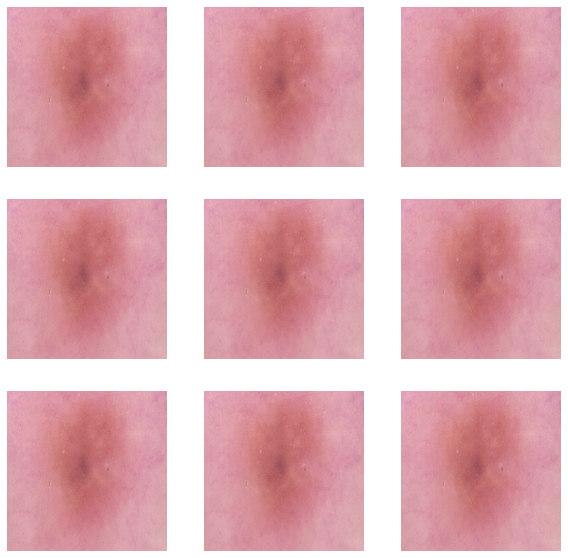

In [60]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
##Now again making the model with 4 convolution layer (with 16, 32, 64 and 128 numbers of features respectively) and then flattening it to a vector of size 256 
##and finally converting it into 9 classifications. We are using relu activation function in each layer except the last one. 
##In the last one softmax function is used. Along with it we are using the data augmentation also and a dropout of 20 percent in every convolution layer.

#### **Todo:** Create your model (make sure to include normalization)

In [61]:
## your code goes here
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Dropout(0.2),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [62]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [63]:
# Model summary 
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 90, 90, 16)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                      

#### **Todo:**  Train your model

In [65]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 31s 176ms/step - loss: 1.1446 - accuracy: 0.5571 - val_loss: 1.2955 - val_accuracy: 0.5078
Epoch 2/50
169/169 [==============================] - 31s 176ms/step - loss: 1.1092 - accuracy: 0.5777 - val_loss: 1.3524 - val_accuracy: 0.4922
Epoch 3/50
169/169 [==============================] - 31s 175ms/step - loss: 1.0818 - accuracy: 0.5901 - val_loss: 1.6036 - val_accuracy: 0.4098
Epoch 4/50
169/169 [==============================] - 30s 175ms/step - loss: 1.0465 - accuracy: 0.6035 - val_loss: 1.2553 - val_accuracy: 0.5249
Epoch 5/50
169/169 [==============================] - 30s 175ms/step - loss: 1.0462 - accuracy: 0.6029 - val_loss: 1.3304 - val_accuracy: 0.5405
Epoch 6/50
169/169 [==============================] - 31s 175ms/step - loss: 0.9726 - accuracy: 0.6263 - val_loss: 1.3050 - val_accuracy: 0.5271
Epoch 7/50
169/169 [==============================] - 31s 176ms/step - loss: 0.9535 - accuracy: 0.6363 - val_loss: 1.0655 - val_ac

#### **Todo:**  Visualize the model results

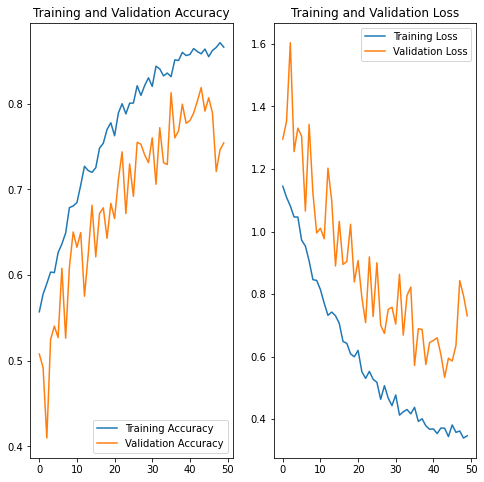

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [67]:
##Now the gap of training and validating accuracy and losses are very less. Also we are getting 72.75 percent accuracy in the validation set. 
##The losses in the validation se is 0.82 which is lesser that previous models

#Now we can say that the model is neither under fitting nor over fitting.